# **Ejemplo de GANs**

# **Importamos Librerias**

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

**Configuramos la semilla generadora aleatoria**

In [2]:
torch.manual_seed(111)

# **Device donde se correra los tensores**

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# **Preprocesamiento de Datos**


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)



La función tiene dos partes:

1) transforms.ToTensor()convierte los datos a un tensor PyTorch.
2) transforms.Normalize()convierte el rango de los coeficientes del tensor.

Los coeficientes originales dados por transforms.ToTensor()van de 0 a 1, y dado que los fondos de las imágenes son negros, la mayoría de los coeficientes son iguales a 0 cuando se representan usando este rango.

# **Cargamos los Datos**

# **MNIST**

In [5]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# **MNIST Fashion**

In [6]:
train_set_fashion = torchvision.datasets.FashionMNIST(
    root=".", train=True, download=True, transform=transform
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



# **Cargador de Datos**



In [7]:
batch_size = 32

# **MNIST**

In [8]:

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

# **MNIST Fashion**

In [9]:
train_loader_fashion = torch.utils.data.DataLoader(
    train_set_fashion, batch_size=batch_size, shuffle=True
)

# **Graficamos los datos de Entrenamiento**

# **MNIST**

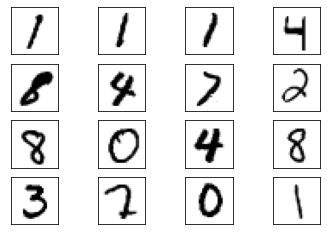

In [10]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# **MNIST Fashion**

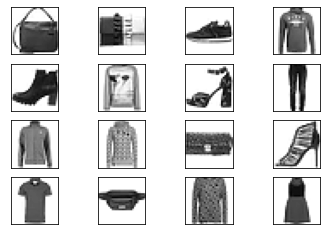

In [11]:
real_samples_fashion, mnist_labels_fashion = next(iter(train_loader_fashion))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples_fashion[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# **Creamos el Modelo GANS**

# **Discriminador**

En este caso, el discriminador es una red neuronal MLP que recibe una imagen de 28 × 28 píxeles y proporciona la probabilidad de que la imagen pertenezca a los datos de entrenamiento reales

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

# **Instancia del Disciminador**

Esta instancia de la red neuronal que ha definido y está lista para ser entrenada.


In [13]:
discriminator = Discriminator().to(device=device)

# **Generador**

El generador generará datos más complejos, es necesario aumentar las dimensiones de la entrada del espacio latente. En este caso, el generador recibirá una entrada de 100 dimensiones y proporcionará una salida con 784 coeficientes, que se organizarán en un tensor de 28 × 28 que representa una imagen.

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output



# **Instancia del Generador**

In [15]:
generator = Generator().to(device=device)

# **Entrenamos el Modelo**

# **Configuramos los hiperparametros**

In [16]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

Primer parametro establece la tasa de aprendizaje, que utilizará para adaptar los pesos de la red.

Segundo parametro establece el número de épocas, que define cuántas repeticiones de entrenamiento se realizarán utilizando todo el conjunto de entrenamiento.

Tercer parametro asigna la variable loss_functiona la función de entropía cruzada binariaBCELoss() , que es la función de pérdida que usará para entrenar los modelos.

# **Configuramos los optimizadores**

Utilizará el algoritmo de Adam para entrenar los modelos discriminador y generador

In [17]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

# **Ciclo de Entrenamiento**

En este las muestras de entrenamiento se alimentan a los modelos y sus pesos se actualizan para minimizar la función de pérdida

Para GAN, actualiza los parámetros del discriminador y el generador en cada iteración de entrenamiento. Como suele hacerse con todas las redes neuronales, el proceso de entrenamiento consta de dos bucles, uno para las épocas de entrenamiento y otro para los lotes de cada época. Dentro del ciclo interno, comienza a preparar los datos para entrenar al discriminador.

# **MNIST**

In [18]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6094037294387817
Epoch: 0 Loss G.: 0.447958767414093
Epoch: 1 Loss D.: 0.0279120784252882
Epoch: 1 Loss G.: 4.570865631103516
Epoch: 2 Loss D.: 0.02930349111557007
Epoch: 2 Loss G.: 8.455808639526367
Epoch: 3 Loss D.: 0.009811594150960445
Epoch: 3 Loss G.: 5.937401294708252
Epoch: 4 Loss D.: 0.041688889265060425
Epoch: 4 Loss G.: 6.049798488616943
Epoch: 5 Loss D.: 0.1747409701347351
Epoch: 5 Loss G.: 4.133143901824951
Epoch: 6 Loss D.: 0.0708828791975975
Epoch: 6 Loss G.: 3.3271234035491943
Epoch: 7 Loss D.: 0.23999358713626862
Epoch: 7 Loss G.: 3.779237747192383
Epoch: 8 Loss D.: 0.3077707290649414
Epoch: 8 Loss G.: 2.6561713218688965
Epoch: 9 Loss D.: 0.2191503942012787
Epoch: 9 Loss G.: 1.8192729949951172
Epoch: 10 Loss D.: 0.4437507390975952
Epoch: 10 Loss G.: 2.10141658782959
Epoch: 11 Loss D.: 0.38217517733573914
Epoch: 11 Loss G.: 2.3097496032714844
Epoch: 12 Loss D.: 0.5474893450737
Epoch: 12 Loss G.: 1.8313695192337036
Epoch: 13 Loss D.: 0.4071493148803711

# **MNIST Fashion**

In [19]:
for epoch in range(num_epochs):
    for n, (real_samples_fashion, mnist_labels_fashion) in enumerate(train_loader_fashion):
        # Data for training the discriminator
        real_samples_fashion = real_samples_fashion.to(device=device)
        real_samples_labels_fashion = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples_fashion = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples_fashion = generator(latent_space_samples_fashion)
        generated_samples_labels_fashion = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples_fashion = torch.cat((real_samples_fashion, generated_samples_fashion))
        all_samples_labels_fashion = torch.cat(
            (real_samples_labels_fashion, generated_samples_labels_fashion)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator_fashion = discriminator(all_samples_fashion)
        loss_discriminator_fashion = loss_function(
            output_discriminator_fashion, all_samples_labels_fashion
        )
        loss_discriminator_fashion.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples_fashion = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples_fashion = generator(latent_space_samples_fashion)
        output_discriminator_generated_fashion = discriminator(generated_samples_fashion)
        loss_generator_fashion = loss_function(
            output_discriminator_generated_fashion, real_samples_labels_fashion
        )
        loss_generator_fashion.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6673077940940857
Epoch: 0 Loss G.: 0.9381358027458191
Epoch: 1 Loss D.: 0.6673077940940857
Epoch: 1 Loss G.: 0.9381358027458191
Epoch: 2 Loss D.: 0.6673077940940857
Epoch: 2 Loss G.: 0.9381358027458191
Epoch: 3 Loss D.: 0.6673077940940857
Epoch: 3 Loss G.: 0.9381358027458191
Epoch: 4 Loss D.: 0.6673077940940857
Epoch: 4 Loss G.: 0.9381358027458191
Epoch: 5 Loss D.: 0.6673077940940857
Epoch: 5 Loss G.: 0.9381358027458191
Epoch: 6 Loss D.: 0.6673077940940857
Epoch: 6 Loss G.: 0.9381358027458191
Epoch: 7 Loss D.: 0.6673077940940857
Epoch: 7 Loss G.: 0.9381358027458191
Epoch: 8 Loss D.: 0.6673077940940857
Epoch: 8 Loss G.: 0.9381358027458191
Epoch: 9 Loss D.: 0.6673077940940857
Epoch: 9 Loss G.: 0.9381358027458191
Epoch: 10 Loss D.: 0.6673077940940857
Epoch: 10 Loss G.: 0.9381358027458191
Epoch: 11 Loss D.: 0.6673077940940857
Epoch: 11 Loss G.: 0.9381358027458191
Epoch: 12 Loss D.: 0.6673077940940857
Epoch: 12 Loss G.: 0.9381358027458191
Epoch: 13 Loss D.: 0.66730779409

# **Evaluamos el Modelo Entrenado**

Se usa algunas muestras aleatorias del espacio latente y se alimentarla al generador para obtener algunas muestras generadas

# **MNIST**

In [20]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

# **MNIST Fashion**

In [21]:
latent_space_samples_fashion = torch.randn(batch_size, 100).to(device=device)
generated_samples_fashion = generator(latent_space_samples_fashion)

Antes de  trazar las muestras generadas y verificar si se parecen a los datos de entrenamiento debemos usar ".detach()" para devolver un tensor del gráfico computacional.

# **Graficamos MNIST**

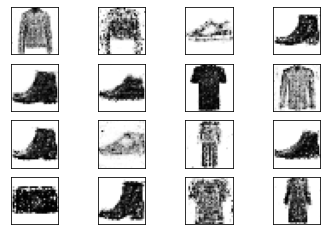

In [24]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# **Graficamos MNIST Fashion**

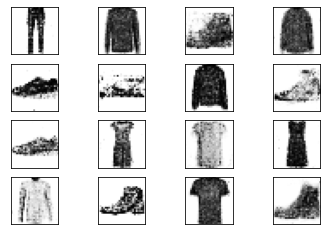

In [25]:
generated_samples_fashion = generated_samples_fashion.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples_fashion[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])